In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# License: MIT
# Date: March 2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

### 1. Data Loading and Preparation

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, :2]  # Take only the first two features
y = iris.target
class_labels = iris.target_names

# Filter for setosa and versicolor flowers
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

In [4]:
X.max(axis=0)

array([7. , 4.4])

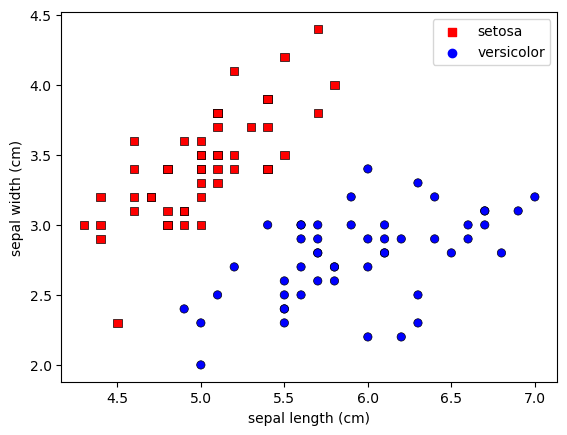

In [5]:
def plot_data(X, y):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=class_labels[y], style=class_labels[y], 
                    palette=['r','b'], markers=('s','o'), edgecolor='k')
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
    plt.legend()    
    
plot_data(X, y)
plt.savefig('figures/iris_data.pdf')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Append a column of ones for the bias term
n_train = X_train_scaled.shape[0]  
n_test = X_test_scaled.shape[0]    
X_train_b = np.hstack((np.ones((n_train, 1)), X_train_scaled))  
X_test_b = np.hstack((np.ones((n_test, 1)), X_test_scaled))     

### 2. Model Implementation

Logistic regression hypothesis: 

$$h_\textbf{w}(\textbf{x}) = p = \sigma(\textbf{w}^T\textbf{x})$$

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

####  2.1 Sigmoid function

In [7]:
def sigmoid(z):    
    return 1 / (1 + np.exp(-z))

#### 2.2 Cost function and gradient

Cost function in logistic regression is:

$$J(\textbf{w}) = -\frac{1}{n}\sum_{i=1}^n\left[y_i \log p_i + (1-y_i)\log(1-p_i)\right]$$

Vectorized implementation:

$\textbf{p} = \sigma(X\textbf{w})$

$J(\textbf{w}) = -\frac{1}{n}\left(\textbf{y}^T \log(\textbf{p})+(\textbf{1}-\textbf{y})^T\log(\textbf{1}-\textbf{p})\right)$



The gradient of the cost is a vector of the same length as $\textbf{w}$ where $j^{th}$ element (for $j=0,1,...,m$) is defined as follows:

$$\frac{\partial J(\textbf{w})}{\partial w_j} = \frac{1}{n} \sum_{i=1}^n [(p_i - y_i) \cdot x_{ij}]$$

Vectorized:
$\nabla J(\textbf{w}) = \frac{1}{n} X^T (\textbf{p} - \textbf{y})$

In [8]:
def cost_function(X, y, w):
    """Compute the logistic regression cost and its gradient.    
    Args:
        X: Feature matrix (with bias term).
        y: Target labels.
        w: Model parameters.
    Returns: Tuple containing the cost and gradient.
    """
    n = len(y)  # Number of examples
    p = sigmoid(np.dot(X, w))  # Predicted probabilities for y = 1
    cost = -(1/n) * (y @ np.log(p) + (1 - y) @ np.log(1 - p))  
    grad = (1/n) * X.T @ (p - y)  # Gradient of the cost

    return cost, grad

#### 2.3 Gradient descent

In [9]:
def optimize_model(X, y, alpha=0.1, max_iter=1000, tol=0.0001):
    """Optimize the model parameters using batch gradient descent.
    Args:
        X: Feature matrix (with bias term).
        y: Target labels.
        alpha: Learning rate.
        max_iter: Maximum number of iterations (epochs) to perform.
        tol: Tolerance for the cost reduction.
    Returns:
        w: The optimized parameters.
        cost_history: The costs from all the training iterations.
    """
    w = np.random.rand(X.shape[1])  # Initialize parameters randomly
    cost_history = []  # Store the cost at each iteration for analysis

    for i in range(max_iter):
        cost, grad = cost_function(X, y, w)  # Compute current cost and gradient        
        w = w - alpha * grad  # Update parameters
        cost_history.append(cost)  # Keep track of the cost

        # Check for convergence
        if i > 0 and (cost_history[-2] - cost) < tol:            
            print(f'Convergence reached after {i} iterations.')
            return w, cost_history

    print('Reached maximum iterations without convergence.')        
    return w, cost_history

In [10]:
w_opt, cost_history = optimize_model(X_train_b, y_train)
print('Optimized weights:', w_opt)

Convergence reached after 395 iterations.
Optimized weights: [ 0.42026863  2.88499483 -2.2992438 ]


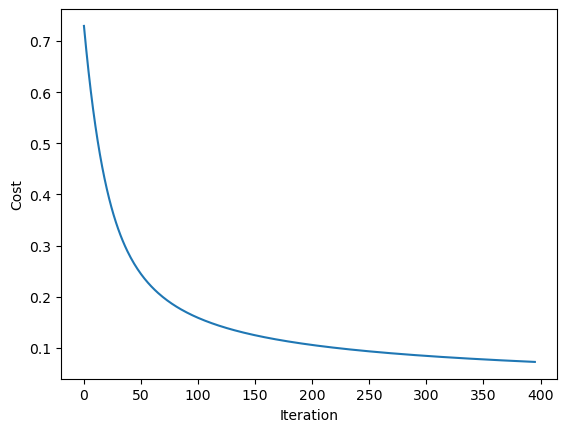

In [11]:
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.savefig('figures/logistic_regression_learning_curve.pdf')

### 3. Using the Model for Predictions

In [12]:
def predict_prob(X, w_opt):
    """Compute the probability of the positive class for samples in X."""
    p = sigmoid(X @ w_opt)
    return p

In [13]:
def predict_prob(X_new, w_opt, scaler):
    """Compute the probability of the positive class for samples in X_new."""
    X_new_scaled = scaler.transform(X_new)  
    X_new_b = np.hstack((np.ones((X_new_scaled.shape[0], 1)), X_new_scaled))  
    p = sigmoid(X_new_b @ w_opt)  
    return p

In [14]:
prob = predict_prob([[6, 2]], w_opt, scaler)
print(prob)

[0.9996311]


In [15]:
prob = predict_prob([[5.5, 3.1]], w_opt, scaler)
print(prob)

[0.59593864]


In [16]:
def predict(X_new, w_opt, scaler, threshold=0.5):
    """Classify samples as 0 or 1 using a probability threshold."""
    p = predict_prob(X_new, w_opt, scaler)
    y_pred = (p >= threshold).astype(int)
    return y_pred

In [17]:
y_pred = predict([[6, 2], [5.5, 3]], w_opt, scaler)
y_pred

array([1, 1])

### 4. Model Evaluation

In [18]:
def evaluate_model(X, y, w_opt, scaler):
    """Calculate the model's accuracy on the given dataset."""
    y_pred = predict(X, w_opt, scaler)  # Predict class labels 
    accuracy = np.mean(y == y_pred)  # Proportion of correct predictions
    return accuracy

In [19]:
train_accuracy = evaluate_model(X_train, y_train, w_opt, scaler)
print(f'Train accuracy: {train_accuracy:.4f}')

test_accuracy = evaluate_model(X_test, y_test, w_opt, scaler)
print(f'Test accuracy: {test_accuracy:.4f}')

Train accuracy: 1.0000
Test accuracy: 1.0000


#### 5. Decision Boundary Visualization

In [20]:
def plot_decision_boundary(X, y, w_opt):
    """Plot the decision boundary between the classes."""
    # Extract the min and max values of the first feature (x1) 
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    
    # Create a range of values for x1
    line_x = np.array([x1_min, x1_max])
    
    # Compute the corresponding y values (x2) using the decision boundary equation
    line_y = -1 / w_opt[2] * (w_opt[1] * line_x + w_opt[0])
    
    # Plot the decision boundary as a dashed line
    plt.plot(line_x, line_y, c='k', ls='--')

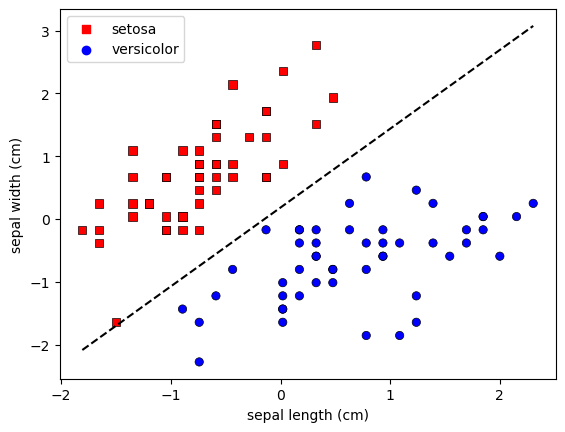

In [21]:
X_scaled = scaler.transform(X)
plot_data(X_scaled, y)
plot_decision_boundary(X_scaled, y, w_opt)
plt.savefig('figures/iris_logistic_decision_boundary.pdf')